In [162]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from random import randint

In [163]:
POPULATION_SIZE = None
INDIVIDUAL_LENGTH = None
CROSSOVER_RATE = None
MUTATION_RATE = None

offsprings = None
generation_count = None
population = None
fitness_values = None
best_value = None
best_individual = None
cities = None
cost_matrix = None

In [175]:
def init():
    global POPULATION_SIZE, INDIVIDUAL_LENGTH, CROSSOVER_RATE, MUTATION_RATE, generation_count, population, fitness_values, best_value, best_individual, cities, cost_matrix
    POPULATION_SIZE = 30
    INDIVIDUAL_LENGTH = 734
    CROSSOVER_RATE = 0.9
    MUTATION_RATE = 0.05
    
    generation_count = 200
    population = np.zeros((POPULATION_SIZE, INDIVIDUAL_LENGTH)).astype(int)
    file = open("data/uy734.tsp", "r")
    cities = []
    lines_skip = 7
    best_value = 1e9
    for i in file.read().split('\n')[lines_skip:lines_skip + INDIVIDUAL_LENGTH]:
        cities.append([float(i.split()[1]), float(i.split()[2])])
    cost_matrix = np.zeros((INDIVIDUAL_LENGTH, INDIVIDUAL_LENGTH))
    for i in range(INDIVIDUAL_LENGTH):
        for j in range(INDIVIDUAL_LENGTH):
            cost_matrix[i,j] = np.linalg.norm(np.array(cities[i]) - np.array(cities[j]))

In [176]:
def init_population():
    global POPULATION_SIZE, INDIVIDUAL_LENGTH, population
    individual = np.arange(INDIVIDUAL_LENGTH)
    np.random.shuffle(individual)

    for i in range(POPULATION_SIZE):
        np.random.shuffle(individual)
        idx = np.argmin(individual)
        population[i] = individual

In [177]:
def evaluate(population):
    global INDIVIDUAL_LENGTH, POPULATION_SIZE, best_value, best_individual
    fitness_values = []
    for i in range(population.shape[0]):
        fitness = 0
        for j in range(population.shape[1]):
            if(j == 0):
                continue
            fitness += cost_matrix[int(population[i,j]), int(population[i,j-1])]
        fitness += cost_matrix[int(population[i,0]), int(population[i,INDIVIDUAL_LENGTH-1])]
        fitness_values.append(fitness)
    
    if(best_value > np.min(fitness_values)):
        best_value = np.min(fitness_values)
        best_individual = population[np.argmin(fitness_values)]
    return fitness_values

In [178]:
#sequential constructive crossover
def SCX(P1,P2,val):
    global INDIVIDUAL_LENGTH
    offspring = []
    offspring.append(0)
    
    mask = np.ones(INDIVIDUAL_LENGTH).astype(int)
    mask[0] = 0
    
    next_dp1 = np.zeros(INDIVIDUAL_LENGTH).astype(int)
    next_dp2 = np.zeros(INDIVIDUAL_LENGTH).astype(int)
    
    curr = (np.where(P1 == 0)[0][0] + val)%INDIVIDUAL_LENGTH
    next_dp1[0] = P1[curr]
    
    while(P1[curr] != 0):
        idx = np.where(P1 == P1[curr])[0][0]
        idx = (idx+val)%INDIVIDUAL_LENGTH
        next_dp1[P1[curr]] = P1[idx]
        curr = idx
        
    curr = (np.where(P2 == 0)[0][0] + val)%INDIVIDUAL_LENGTH
    next_dp2[0] = P2[curr]
    while(P2[curr] != 0):
        idx = np.where(P2 == P2[curr])[0][0]
        idx = (idx+val)%INDIVIDUAL_LENGTH
        next_dp2[P2[curr]] = P2[idx]
        curr = idx

    while(len(offspring) < INDIVIDUAL_LENGTH):
        last_node = offspring[-1]
        dp1 = last_node
        dp2 = last_node 
        while(mask[int(dp1)] == 0):
            dp1 = next_dp1[int(dp1)]
        while(mask[int(dp2)] == 0):
            dp2 = next_dp2[int(dp2)]
        if(cost_matrix[int(last_node), int(dp1)] <= cost_matrix[int(last_node), int(dp2)]):
            offspring.append(int(dp1))
            mask[int(dp1)] = 0
        else:
            offspring.append(dp2)
            mask[int(dp2)] = 0
    return offspring

In [179]:
#partially mapped crossover
def PMX(P1,P2):
    global INDIVIDUAL_LENGTH
    offspring1 = P1.copy()
    offspring2 = P2.copy()
    
    next_dp1 = np.zeros(INDIVIDUAL_LENGTH).astype(int)
    next_dp2 = np.zeros(INDIVIDUAL_LENGTH).astype(int)
    
    for idx, val in enumerate(P1):
        next_dp1[int(val)] = idx
    for idx, val in enumerate(P2):
        next_dp2[int(val)] = idx
    
    m = randint(0, INDIVIDUAL_LENGTH)
    
    for index in range(m, int(m +INDIVIDUAL_LENGTH/2)):
        i = index%INDIVIDUAL_LENGTH
        idx = next_dp1[P2[i]]
        offspring1[i], offspring1[idx] = offspring1[idx], offspring1[i]
    
    for index in range(m, int(m +INDIVIDUAL_LENGTH/2)):
        i = index%INDIVIDUAL_LENGTH
        idx = next_dp2[P1[i]]
        offspring2[i], offspring2[idx] = offspring2[idx], offspring2[i]
    
    return offspring1, offspring2

In [180]:
def mutate(individual, prob):
    global INDIVIDUAL_LENGTH
    if(prob >= 0.5):
        m = INDIVIDUAL_LENGTH
        n = 0
        while(n < m or m ==0):
            m = randint(1, INDIVIDUAL_LENGTH)
            n = randint(1, INDIVIDUAL_LENGTH)
        individual[m:n] = individual[m:n][::-1]
    else:
        m = INDIVIDUAL_LENGTH
        n = 0
        while(n < m or m ==0):
            m = randint(1, INDIVIDUAL_LENGTH)
            n = randint(1, INDIVIDUAL_LENGTH)
        clone = individual.copy()
        individual[1:(n-m+1)], individual[(n-m+1):n] = clone[m:n], clone[1:m]
    return individual

In [181]:
def mutation(population):
    global MUTATION_RATE
    mutant = []
    for i in range(population.shape[0]):
        if(i==0):
            continue
        if(np.random.sample() < MUTATION_RATE):
            mutant.append(mutate(population[i].copy(),np.random.sample()))
    return mutant

In [182]:
def crossover():
    global population, POPULATION_SIZE, CROSSOVER_RATE
    crossover_list = []
    for i in range(POPULATION_SIZE):
        if(np.random.sample() < CROSSOVER_RATE):
            crossover_list.append(i)
    np.random.shuffle(crossover_list)
    offsprings = []
    for i in range(0, len(crossover_list)-1, 2):
        idx1 = crossover_list[i]
        idx2 = crossover_list[i+1]
        offsprings.append(SCX(population[idx1].copy(), population[idx2].copy(), 1))
        offsprings.append(SCX(population[idx1].copy(), population[idx2].copy(), -1))
    return offsprings
    

In [183]:
def selection(epopulation,fitness):
    global POPULATION_SIZE
    size = epopulation.shape[0]
    population = []
    population.append(epopulation[np.argmin(fitness)])
    for i in range(1, POPULATION_SIZE):
        m = randint(0, size-1)
        n = randint(0, size-1)
        while(m==n):
            n = randint(0, size-1)
        if(fitness[m] < fitness[n]):
            population.append(epopulation[m])
        else:
            population.append(epopulation[n])
    return population
    

In [184]:
init()
init_population()

In [185]:
generation_count = 1000
for i in range(generation_count):
    offsprings = crossover()
    epopulation = np.concatenate((population, np.array(offsprings)), axis = 0)
    mutants = mutation(epopulation)
    if(np.array(mutants).shape[0]):
        epopulation = np.concatenate((epopulation, np.array(mutants)), axis = 0)
    fitness = evaluate(epopulation)
    population = selection(epopulation,fitness)
    print("Generation", i+1)
    print("Best value", best_value)
    print("Generation best fitness", fitness[np.argmin(fitness)])

Generation 1
Best value 1224990.8969614813
Generation best fitness 1224990.8969614813
Generation 2
Best value 965825.3205100659
Generation best fitness 965825.3205100659
Generation 3
Best value 843305.5503558979
Generation best fitness 843305.5503558979
Generation 4
Best value 711027.8230143841
Generation best fitness 711027.8230143841
Generation 5
Best value 635493.9577755986
Generation best fitness 635493.9577755986
Generation 6
Best value 560745.0183497376
Generation best fitness 560745.0183497376
Generation 7
Best value 499015.90165530366
Generation best fitness 499015.90165530366
Generation 8
Best value 444913.07988032495
Generation best fitness 444913.07988032495
Generation 9
Best value 413781.95440200594
Generation best fitness 413781.95440200594
Generation 10
Best value 375740.832543898
Generation best fitness 375740.832543898
Generation 11
Best value 357516.0449704697
Generation best fitness 357516.0449704697
Generation 12
Best value 327854.7710465128
Generation best fitness 3

KeyboardInterrupt: 

29908.260623316688


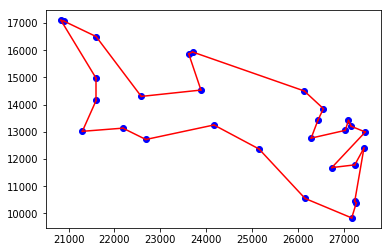

In [92]:
print(best_value)
plot_cities = np.array(cities)
plt.plot(plot_cities[:,0], plot_cities[:,1], 'bo')
for i in range(INDIVIDUAL_LENGTH):
    if(i == 0):
        city_idx_prev = int(best_individual[0])
        city_idx = int(best_individual[INDIVIDUAL_LENGTH-1])
        plt.plot(plot_cities[(city_idx_prev,city_idx),0], plot_cities[(city_idx_prev,city_idx),1], 'r-')
        continue
    city_idx_prev = int(best_individual[i-1])
    city_idx = int(best_individual[i])
    plt.plot(plot_cities[(city_idx_prev,city_idx),0], plot_cities[(city_idx_prev,city_idx),1], 'r-')
    
plt.show()